In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import OptPairTensor, Adj, Size, NoneType, OptTensor

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree
from torch_geometric.data import Data

import tqdm
import livelossplot

In [2]:
plt.style.use("dark_background")

In [3]:
%cd ..

/home/kuba/Projects/github_search


## 1. make pyg graph from repositories

In [ ]:
dependency_records_df = pd.read_csv(
    "output/dependency_records.csv", encoding="latin-1"
).dropna()  # .iloc[:1000000]

In [ ]:
non_root_dependency_records_df = dependency_records_df[
    dependency_records_df["source"] != "<ROOT>"
]

In [ ]:
from github_search.pytorch_geometric_networks import *

## FastText token features

In [ ]:
import fasttext
from mlutil.feature_extraction import embeddings
import os
from toolz import partial

from github_search.pytorch_geometric_training import train_unsupervised_graphsage_model

In [8]:
fasttext_model = fasttext.load_model(
    os.path.join(os.getcwd(), "output/python_fasttext.bin")
)

In [9]:
fasttext_embedder = embeddings.FastTextVectorizer(fasttext_model)

In [ ]:
dependency_graph_wrapper = PygGraphWrapper(
    fasttext_embedder.transform, non_root_dependency_records_df
)

In [14]:
dependency_graph_wrapper.dataset

Data(x=[1382270, 100], edge_index=[2, 7507078])

In [7]:
from github_search.pytorch_geometric_training import *

In [8]:
%cd ..

/home/kuba/Projects/github_search


In [14]:
fasttext_model_path = "output/python_files_fasttext_dim200.bin"
dependency_graph_wrapper = get_dataset(fasttext_model_path)

KeyboardInterrupt: 

In [16]:
dependency_graph_wrapper.dataset

Data(x=[1382270, 200], edge_index=[2, 7507078])

In [ ]:
sampler = SAGENeighborSampler()

In [13]:
skip_connections = False
hidden_channels = 200
num_layers = 2
use_x_in = True
epochs = 50
lr = 0.001


print("skip connections:", skip_connections)
print("hidden channels:", hidden_channels)
print("loading data")
data = dependency_graph_wrapper.dataset
if skip_connections:
    sage_layer = ResidualSAGEConv
else:
    sage_layer = SAGEConv

model = train_unsupervised_graphsage_model(
    data, sage_layer, hidden_channels, num_layers, epochs, lr
).to(device)
# torch.save(model, str(product["model_path"]))

model = model.to("cpu")
graphsage_features = model.full_forward(data.x, data.edge_index).cpu().detach().numpy()
graphsage_kv = KeyedVectors(graphsage_features.shape[1])
graphsage_kv.add(
    dependency_graph_wrapper.inverse_vertex_mapping.values, graphsage_features
)
# graphsage_kv.save(str(product["graphsage_token_embeddings"]))

example_repo = "huggingface/transformers"


def get_most_similar_repos(example_repo, n_repos):
    similarities = metrics.pairwise.cosine_distances(
        [graphsage_features[dependency_graph_wrapper.vertex_mapping[example_repo]]],
        graphsage_features,
    )[0]
    repo_inverse_vertex_mapping = dependency_graph_wrapper.inverse_vertex_mapping
    repo_inverse_vertex_mapping = repo_inverse_vertex_mapping[
        repo_inverse_vertex_mapping.str.contains("/")
    ]
    return dependency_graph_wrapper.inverse_vertex_mapping[
        (similarities[: len(repo_inverse_vertex_mapping)]).argsort()[:n_repos]
    ]


print(get_most_similar_repos("open-mmlab/mmsegmentation", 20))
print(get_most_similar_repos("pytorch/pytorch", 20))
print(get_most_similar_repos("open-mmlab/mmsegmentation", 20))

skip connections: False
hidden channels: 200
loading data


  0%|          | 0/50 [00:00<?, ?it/s]


AssertionError: 

In [16]:
model = train_unsupervised_graphsage_model(
    data=dependency_graph_wrapper.dataset,
    sage_layer=ResidualSAGEConv,
    hidden_channels=100,
    num_layers=3,
    epochs=50,
    lr=0.01,
    in_jupyter=True,
)

IndexError: index 17592186930749 is out of bounds for dimension 0 with size 7507078

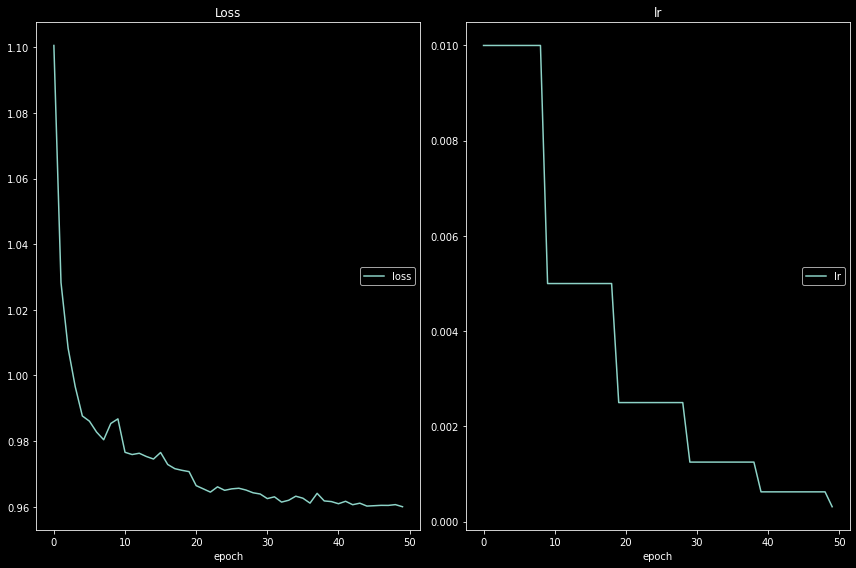

Loss
	loss             	 (min:    0.960, max:    1.101, cur:    0.960)
lr
	lr               	 (min:    0.000, max:    0.010, cur:    0.000)


In [11]:
model = train_unsupervised_graphsage_model(
    data=dependency_graph_wrapper.dataset,
    sage_layer=partial(SAGEConv, root_weight=False),
    hidden_channels=100,
    num_layers=2,
    epochs=50,
    lr=0.01,
    in_jupyter=True,
)

In [12]:
torch.save(model, "output/graphsage_model_no_root.pth")

In [13]:
model = model.cpu()

In [14]:
%%time
graphsage_features = (
    model.full_forward(
        dependency_graph_wrapper.dataset.x, dependency_graph_wrapper.dataset.edge_index
    )
    .cpu()
    .detach()
    .numpy()
)

CPU times: user 28.7 s, sys: 9.95 s, total: 38.7 s
Wall time: 16.6 s


In [15]:
repos = dependency_graph_wrapper.inverse_vertex_mapping[
    dependency_graph_wrapper.inverse_vertex_mapping.str.contains("/")
].values

In [16]:
repo_features = dependency_graph_wrapper.get_vertex_embeddings(repos, model)

In [17]:
from gensim.models import KeyedVectors


graphsage_kv = KeyedVectors(graphsage_features.shape[1])
graphsage_kv.add(
    dependency_graph_wrapper.inverse_vertex_mapping.values, graphsage_features
)

In [18]:
graphsage_kv.save("output/graphsage_embeddings.bin")

In [19]:
dependency_graph_wrapper.vertex_mapping.shape

(1382270,)

In [20]:
example_repo = "huggingface/transformers"
dependency_graph_wrapper.vertex_mapping[example_repo]

9981

In [21]:
dependency_graph_wrapper.inverse_vertex_mapping

0          0492wzl/tensorflow_slim_densenet
1                             08173021/FCOS
2                        09jvilla/CS234_gym
3                0h-n0/cdn_molecule_pytorch
4                            0h-n0/tfdbonas
                         ...               
1382265                     loss_accountant
1382266                    delta_accountant
1382267                 accuracy_accountant
1382268                         participate
1382269                         coincidence
Length: 1382270, dtype: object

In [22]:
dependency_graph_wrapper.inverse_vertex_mapping[
    dependency_graph_wrapper.inverse_vertex_mapping.str.contains("bert")
][:50]

182      AbertayMachineLearningGroup/zero-day-detection
201                           AdalbertoCq/Pathology-GAN
263                           AlbertoParravicini/grcuda
371           AndriyMulyar/bert_document_classification
460              ArthurRizar/dialog_state_tracking_bert
1153                     DeligientSloth/bert-tensorflow
1360                       EthanWYB/bert-classification
1946                                   IIEKES/cbert_aug
2070                                     JNUpython/bert
2542                               LeoWood/bert-horovod
3171                      Nstats/bert_senti_analysis_ch
3323                  PaulAlbert31/LabelNoiseCorrection
3324                                 PaulAlbert31/ReLaB
3596                               RenXiangyuan/tf_bert
3633                             RobertHong1992/Resnest
3634             RobertJaro/SolarImageQualityAssessment
3765                    SYangDong/bert-with-frozen-code
4027                            Soikonomou/alber

In [34]:
from sklearn import metrics

In [38]:
def get_most_similar_repos(example_repo, n_repos):
    similarities = metrics.pairwise.cosine_distances(
        [repo_features[dependency_graph_wrapper.vertex_mapping[example_repo]]],
        repo_features,
    )[0]
    repo_inverse_vertex_mapping = dependency_graph_wrapper.inverse_vertex_mapping
    repo_inverse_vertex_mapping = repo_inverse_vertex_mapping[
        repo_inverse_vertex_mapping.str.contains("/")
    ]
    return dependency_graph_wrapper.inverse_vertex_mapping[
        (similarities[: len(repo_inverse_vertex_mapping)]).argsort()[:n_repos]
    ]

In [39]:
get_most_similar_repos(example_repo, 20)

9981                              huggingface/transformers
2057                                     JDAI-CV/fast-reid
18630                                zawlin/cvpr17_vtranse
7882                              dermatologist/nlp-qrmine
17951                       wuyuejinxia/prcv2019-mvb-renet
7002                   chaoyanghe/bipartite-graph-learning
6449                    bettenW/Tencent2019_Finals_Rank1st
10109           ibkuroyagi/Mechanisms-of-Action-Prediction
16924                             toamto94/Ising-Knockoffs
4882                                YuhangSong/Mega-Reward
3701                              SAP/machine-learning-dgm
4757                                            Xovee/ccgl
4995                                       ZhengyuZhao/ACE
10834    joe-prog/https-github.com-facebookresearch-ParlAI
16764                    thongonary/TopologyClassification
1426                         Feynman27/pytorch-detect-rfcn
6349                                         bccp/nbodyk

In [42]:
get_most_similar_repos("open-mmlab/mmsegmentation", 20)

13903                            open-mmlab/mmsegmentation
17526    vishalshar/covid-19-screening-using-RAN-on-X-r...
7555                                    d222nguy/pygcn_new
13155                mrheffels/aerial-imagery-segmentation
17445                                         vhvkhoa/sort
65                                 4uiiurz1/pytorch-adacos
14008                            p2irc/deepwheat_WACV-2018
1601                           GokulKarthik/LSTNet.pytorch
12396               marcinglowacki/wise_redshift_estimator
11849                                       lilanger/SHEMS
13814                     ofirpress/YouMayNotNeedAttention
2914                                    Microsoft/LightGBM
7658                                 dargilboa/SBPS-public
10854                               johannbrehmer/madminer
13076                          mondejar/ecg-classification
527                                       BBillot/SynthSeg
17394                  varinf/TransformersDataAugmentati

In [43]:
get_most_similar_repos("pytorch/pytorch", 20)

14558                     pytorch/pytorch
8981           foamliu/Deep-Image-Matting
7516       cxt98/Densefusion-transparency
13899                opconty/pytorch_ctpn
8763                     fadymedhat/MCLNN
10201                     iitmcvg/redtail
4440                       UKPLab/kg2text
1722               Ha0Tang/LocalGlobalGAN
12165      lukemelas/EfficientNet-PyTorch
8069       dmmiller612/lecture-summarizer
7173                      ckczzj/AAAI2020
4733            Xiangyi1996/PPNet-PyTorch
10778              jkcracker/colorization
14096                      paulorauber/nn
18492                  ysoullard/CTCModel
18897                        zsethna/OLGA
10965    js-aguiar/wheat-object-detection
3688                  RyanWangZf/CVIB-Rec
17478                    vihari/crossgrad
14192                peteryuX/arcface-tf2
dtype: object